# Vectorized model
The consumer and resource dynamics in the simulation is calculated using the vectorized version of equations 1 & 2 for computing efficiency: 

\begin{equation}
d\mathbf{C}/dt = diag(\mathbf{C}) \circ ((1-l) \mathbf{U} \cdot \mathbf{S} - \mathbf{R})
\end{equation}

\begin{equation}
d\mathbf{S}/dt = \mathbf{\rho} - diag(\mathbf{S})\cdot \mathbf{U}^T \cdot \mathbf{C} + diag(\mathbf{S}) \cdot (\mathbf{U} \cdot \mathbf{l})^T \cdot \mathbf{C}
\end{equation}

In these equations, $\mathbf{C}$ and $\mathbf{S}$ are single row matrices of consumer and resource concentration at each time point. $\mathbf{U}$ is the N $\times$ M matrix of species uptake rate, $\mathbf{R}$ is the single row matrix of species respiration rate with the length of N. $\mathbf{l}$ is the M $\times$ M leakage matrix for M resources, and l is the set leakage fraction of resources. "$\circ$" denotes the element wise product of two matrices, "$\cdot$" represents matrix multiplication, and "T" is the transpose of matrix. $diag(\mathbf{S})$ is setting the resource concentration at each time point onto the diagonal of M $\times$ M matix with the rest of the elements being 0, which notation makes the calculation equivalent to calculating row-wise products of $\mathbf{U}$ and $\mathbf{S}$. 

In [1]:
from Bacteria_vector_modular import ass_temp_run
import matplotlib.pylab as plt
import numpy as np
from matplotlib.lines import Line2D
import warnings
warnings.filterwarnings('ignore')

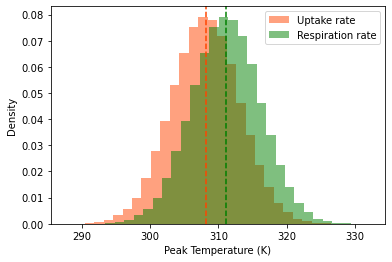

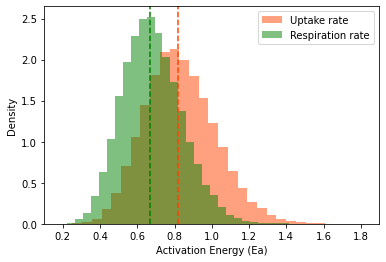

In [2]:
N = 50000
T_pk_U = 273.15 + np.random.normal(35, 5, size = N) # Peak temperature for uptake
T_pk_R = T_pk_U + 3 # Peak temperature for respiration
plt.hist(T_pk_U, 30, color = "orangered", density = True, alpha = 0.5, label = "Uptake rate")
plt.hist(T_pk_R, 30, color = "g", density = True, alpha = 0.5, label = "Respiration rate")
plt.axvline(273.15+35, color="orangered", linestyle='dashed') # Mean
plt.axvline(273.15+38, color='g', linestyle='dashed') # Mean
plt.xlabel("Peak Temperature (K)")
plt.ylabel("Density")
plt.legend()
plt.show()

a = 15 # The alpha value for beta distribution in Ea
Ea_U = np.random.beta(a, ((a - 1/3) / (0.82/4)) + 2/3 - a, N)*4 # Activation energy for uptake
Ea_R = np.random.beta(a, ((a - 1/3) / (0.67/4)) + 2/3 - a, N)*4 # Activation energy for respiration

plt.hist(Ea_U, 30, color = "orangered", density = True, alpha = 0.5, label = "Uptake rate")
plt.hist(Ea_R, 30, color = "g", density = True, alpha = 0.5, label = "Respiration rate")
plt.axvline(0.82, color="orangered", linestyle='dashed') # Median
plt.axvline(0.67, color='g', linestyle='dashed') # Median
plt.xlabel("Activation Energy (Ea)")
plt.ylabel("Density")
plt.legend()
plt.show()

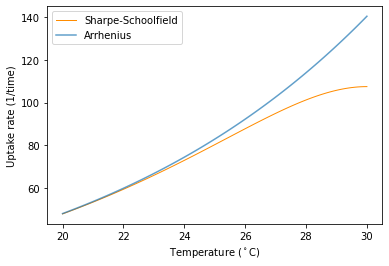

In [3]:
k = 0.0000862 # Boltzman constant
Tref = 273.15 + 0 # Reference temperature
lf = 0.4 # Leakage fraction
T = 273.15 + np.linspace(20,30,100) # Temperatures
T_pk_U = 273.15 + 30 # Peak temperature for uptake
Ea_D = 3.5 # High temperature inactivation
B_U = 4.47 # Normalization constant for uptake 
Ea_U = 0.82 # Activation energy for uptake

U_Sharpe = B_U * np.exp((-Ea_U/k) * ((1/T)-(1/Tref)))/(1 + (Ea_U/(Ea_D - Ea_U)) * np.exp(Ea_D/k * (1/T_pk_U - 1/T))) 

plt.plot(T - 273.15, U_Sharpe, 'darkorange', linewidth=1, label = "Sharpe-Schoolfield")
plt.plot(T - 273.15, B_U * np.exp((-Ea_U/k) * ((1/T)-(1/Tref))), label = "Arrhenius", alpha = 0.7)
plt.xlabel("Temperature ($^\circ$C)")
plt.ylabel("Uptake rate (1/time)")
plt.legend()
plt.show()

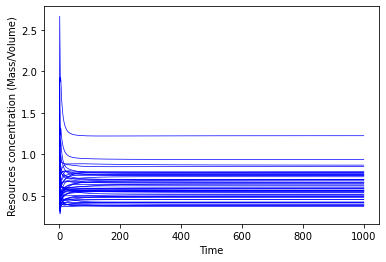

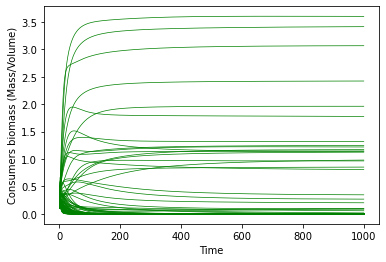

In [4]:
########## Setting Parameters ###########
N = 100 # Number of consumers
M = 50 # Number of resources

# Temperature parameters
T = 273.15 + 0 # Temperature
Tref = 273.15 + 0 # Reference temperature
Ma = 1 # Mass
Ea_D = np.repeat(3.5,N) # High temperature inactivation
lf = 0.4 # Leakage fraction
p_value = 1 # External resource supply

# Assembly
ass = 1 # Assembly times at each temperature
t_fin = 1000 # Number of time steps for each temperature
typ = 1 # Functional response, Type I or II
K = 0 # Half saturation constant for Monod equation(Type II)

########## Running Model ###########
np.random.seed(9999)
result_array, rich_series, l, U_out_total, R_out, CUE_out, Ea_CUE_out, overlap, crossf, Sr = ass_temp_run(t_fin, N, M, T, Tref, Ma, ass, Ea_D, lf, p_value, typ, K)

t_plot = np.linspace(0,t_fin,t_fin)

plt.plot(t_plot, result_array[:,N:N+M], 'b-', linewidth=0.7)
plt.ylabel('Resources concentration (Mass/Volume)')
plt.xlabel('Time')
plt.show()

plt.plot(t_plot, result_array[:,0:N], 'g-', linewidth=0.7)
plt.ylabel('Consumers biomass (Mass/Volume)')
plt.xlabel('Time')
plt.show()


22.8


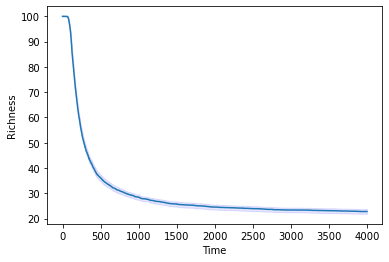

In [5]:
# Assembly
ass = 30 # Assembly times at each temperature
t_fin = 4000 # Number of time steps for each temperature

########## Running Model ###########
result_array, rich_series, l, U_out_total, R_out, CUE_out, Ea_CUE_out, overlap, crossf, Sr = ass_temp_run(t_fin, N, M, T, Tref, Ma, ass, Ea_D, lf, p_value, typ, K)
print(np.mean(rich_series))

rich = np.array([len(np.where(result_array[i,0:N])[0]) for i in range(len(result_array))]).reshape(ass,t_fin)
rich_mean = np.mean(rich, axis = 0)
rich_ci = 1.96 * np.std(rich,axis = 0)/(ass**0.5)

t_plot = np.linspace(0,t_fin,t_fin)

plt.plot(t_plot, rich_mean)
plt.fill_between(t_plot, rich_mean - rich_ci, rich_mean + rich_ci, color = 'b', alpha=.1)
plt.ylabel('Richness')
plt.xlabel('Time')
plt.show()

[[0.1       0.1      ]
 [0.3125389 0.3125389]
 [0.3692801 0.3692801]
 [0.2968873 0.2968873]
 [0.2813829 0.2813829]
 [0.2918501 0.2918502]
 [0.2965534 0.2965535]
 [0.2948773 0.2948774]
 [0.2937118 0.293712 ]
 [0.2939117 0.2939118]]
[[0.63333336 0.63333334]]


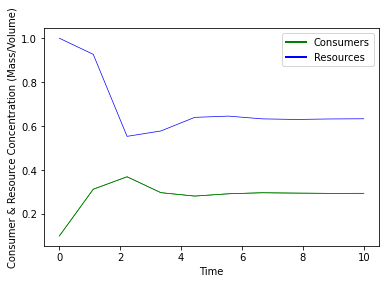

In [6]:
########## Setting Parameters ###########
N = 2 # Number of consumers
M = 1 # Number of resources

# Temperature params
T = 273.15 + 0 # Temperature
Tref = 273.15 + 0 # Reference temperature Kelvin
Ma = 1 # Mass
Ea_D = np.repeat(3.5,N) # High temperature inactivation
lf = 0.4 # Leakage fraction
p_value = 1 # External resource supply

# Assembly
ass = 1 # Assembly times at each temperature
t_fin = 10 # Number of time steps for each temperature
typ = 1 # Functional response, Type I or II
K = 0 # Half saturation constant for Monod equation(Type II)

########## Running Model ###########
np.random.seed(9999)
result_array, rich_series, l, U_out_total, R_out, CUE_out, Ea_CUE_out, overlap, crossf, Sr = ass_temp_run(t_fin, N, M, T, Tref, Ma, ass, Ea_D, lf, p_value, typ, K)

print(result_array[:,0:N])
S0 = R_out/(np.sum(U_out_total, axis = 1) * (1 - lf))
print(S0)

rich = np.array([len(np.where(result_array[i,0:N])[0]) for i in range(len(result_array))]).reshape(ass,t_fin)
rich_mean = np.mean(rich, axis = 0)
rich_ci = 1.96 * np.std(rich,axis = 0)/(ass**0.5)

t_plot = np.linspace(0,len(result_array),len(result_array))

plt.plot(t_plot, result_array[:,N:N+M], 'b-', linewidth=0.7, label = "Resources")
plt.plot(t_plot, result_array[:,0:N], 'g-', linewidth=0.7, label = "Consumers")
plt.ylabel('Consumer & Resource Concentration (Mass/Volume)')
plt.xlabel('Time')
plt.legend([Line2D([0], [0], color='green', lw=2), Line2D([0], [0], color='blue', lw=2)], ['Consumers', 'Resources'])
plt.show()

[[1.000000e-01 1.000000e-01]
 [1.045357e-01 1.580000e-05]
 [7.592200e-02 0.000000e+00]
 [7.014990e-02 0.000000e+00]
 [6.886100e-02 0.000000e+00]]
[[0.36766784 0.512935  ]]


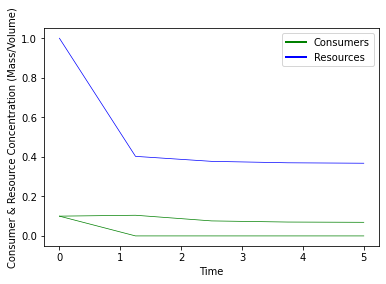

In [7]:
# Temperature params
T = 273.15 + 25 # Temperature
Tref = 273.15 + 0 # Reference temperature
t_fin = 5 # Number of time steps for each temperature

########## Running Model ###########
np.random.seed(99)
result_array, rich_series, l, U_out_total, R_out, CUE_out, Ea_CUE_out, overlap, crossf, Sr = ass_temp_run(t_fin, N, M, T, Tref, Ma, ass, Ea_D, lf, p_value, typ, K)

print(result_array[:,0:N])
S0 = R_out/(np.sum(U_out_total, axis = 1) * (1 - lf))
print(S0)

rich = np.array([len(np.where(result_array[i,0:N])[0]) for i in range(len(result_array))]).reshape(ass,t_fin)
rich_mean = np.mean(rich, axis = 0)
rich_ci = 1.96 * np.std(rich,axis = 0)/(ass**0.5)

t_plot = np.linspace(0,len(result_array),len(result_array))

plt.plot(t_plot, result_array[:,N:N+M], 'b-', linewidth=0.7, label = "Resources")
plt.plot(t_plot, result_array[:,0:N], 'g-', linewidth=0.7, label = "Consumers")
plt.ylabel('Consumer & Resource Concentration (Mass/Volume)')
plt.xlabel('Time')
plt.legend([Line2D([0], [0], color='green', lw=2), Line2D([0], [0], color='blue', lw=2)], ['Consumers', 'Resources'])
plt.show()

## Type II

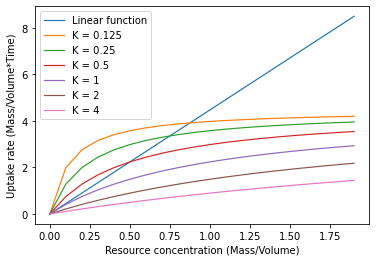

In [8]:
x = np.arange(0, 2, 0.1) # Resource concentration
plt.plot(x, 4.47*x, linewidth = 1.2, label = 'Linear function')
for i in range(6):
    K = 2**(i - 3) # Half saturation constant for Monod equation(Type II)
    plt.plot(x, 4.47*x/(K+x), linewidth = 1.2, label = 'K = %s' %K)
plt.legend()
plt.ylabel('Uptake rate (Mass/Volume*Time)')
plt.xlabel('Resource concentration (Mass/Volume)')
plt.show()

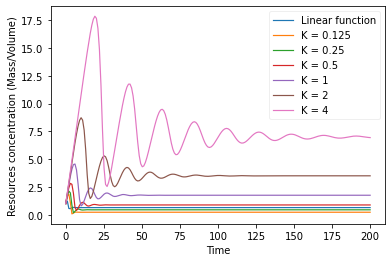

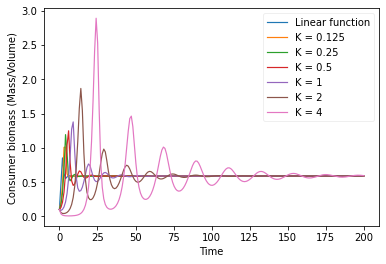

In [9]:
########## Setting Parameters ###########
N = 1 # Number of consumers
M = 1 # Number of resources

# Temperature params
T = 273.15 + 0 # Temperature
Tref = 273.15 + 0 # Reference temperature
Ma = 1 # Mass
Ea_D = np.repeat(3.5,N) # High temperature inactivation
lf = 0.4 # Leakage fraction
p_value = 1 # External resource supply

# Assembly
ass = 1 # Assemblies at each temperature
t_fin = 200 # Number of time steps for each temperature

########## Running Model ###########

t_plot = np.linspace(0,t_fin,t_fin)

typ = 1 # Functional response, Type I or II
K = 1 # Half saturation constant for Monod equation(Type II)
np.random.seed(99)
result_array = ass_temp_run(t_fin, N, M, T, Tref, Ma, ass, Ea_D, lf, p_value, typ, K)[0]
plt.plot(t_plot, result_array[:,N:N+M], linewidth= 1.2, label = 'Linear function')
typ = 2 # Functional response, Type I or II
for i in range(6):
    K = 2**(i - 3) # Half saturation constant for Monod equation(Type II)
    np.random.seed(99)
    result_array = ass_temp_run(t_fin, N, M, T, Tref, Ma, ass, Ea_D, lf, p_value, typ, K)[0]
    plt.plot(t_plot, result_array[:,N:N+M], linewidth= 1.2, label = 'K = %s' %K)
plt.legend(framealpha = 0.3, loc = 1)
plt.ylabel('Resources concentration (Mass/Volume)')
plt.xlabel('Time')
plt.show()

typ = 1 # Functional response, Type I or II
K = 1 # Half saturation constant for Monod equation(Type II)
np.random.seed(99)
result_array = ass_temp_run(t_fin, N, M, T, Tref, Ma, ass, Ea_D, lf, p_value, typ, K)[0]
plt.plot(t_plot, result_array[:,0:N], linewidth= 1.2, label = 'Linear function')
typ = 2 # Functional response, Type I or II
for i in range(6):
    K = 2**(i - 3) # Half saturation constant for Monod equation(Type II)
    np.random.seed(99)
    result_array = ass_temp_run(t_fin, N, M, T, Tref, Ma, ass, Ea_D, lf, p_value, typ, K)[0]
    plt.plot(t_plot, result_array[:,0:N], linewidth= 1.2, label = 'K = %s' %K)
plt.legend(framealpha = 0.3, loc = 1)
plt.ylabel('Consumer biomass (Mass/Volume)')
plt.xlabel('Time')
plt.show()


In [ ]:
########## Setting Parameters ###########
N = 100 # Number of consumers
M = 50 # Number of resources

# Temperature params
Tref = 273.15 + 0 # Reference temperature Kelvin
Ma = 1 # Mass
Ea_D = np.repeat(3.5,N) # High temperature inactivation
lf = 0.4 # Leakage fraction
p_value = 1 # External resource supply

# Assembly
ass = 30 # Assemblies at each temperature
t_fin = 4000 # Number of time steps for each temperature
T_c = 26 # How many temperatures to cover

T_plot = range(0, T_c, 1)

typ = 1 # Functional response, Type I or II
K = 0
rich = np.empty((0, ass))
for i in range(T_c):
    T = 273.15 + i # Temperature
    result_array, rich_series, l, U_out_total, R_out, CUE_out, Ea_CUE_out, overlap, crossf, Sr = ass_temp_run(t_fin, N, M, T, Tref, Ma, ass, Ea_D, lf, p_value, typ, K)
    rich = np.append(rich, [rich_series.flatten()], axis = 0)

rich_mean = np.mean(rich, axis = 1)
rich_ci =  1.96 * np.std(rich,axis = 1)/(ass**0.5)
plt.plot(T_plot, rich_mean, linewidth= 1, label = 'Linear function')
plt.fill_between(T_plot, rich_mean - rich_ci, rich_mean + rich_ci, alpha=.1)


typ = 2 # Functional response, Type I or II
for j in range(6):
    K = 2**(j - 3) # Half saturation constant for Monod equation(Type II)
    rich = np.empty((0, ass))

    for i in range(T_c):
        T = 273.15 + i # Temperature
        result_array, rich_series, l, U_out_total, R_out, CUE_out, Ea_CUE_out, overlap, crossf, Sr = ass_temp_run(t_fin, N, M, T, Tref, Ma, ass, Ea_D, lf, p_value, typ, K)
        rich = np.append(rich, [rich_series.flatten()], axis = 0)

    rich_mean = np.mean(rich, axis = 1)
    rich_ci =  1.96 * np.std(rich,axis = 1)/(ass**0.5)
    plt.plot(T_plot, rich_mean, label = 'K = %s' %K)
    plt.fill_between(T_plot, rich_mean - rich_ci, rich_mean + rich_ci, alpha=.1)

plt.xlabel('Temperature ($^\circ$C)')
plt.ylabel('Richness')
plt.legend()
plt.show()
    
print((time.time() - start)/60)

# $E_U$ = $E_R$

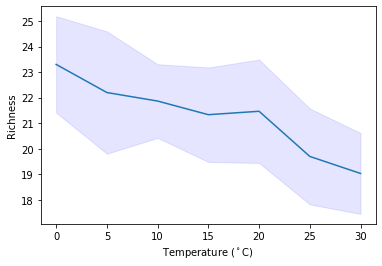

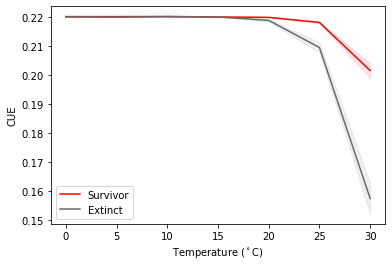

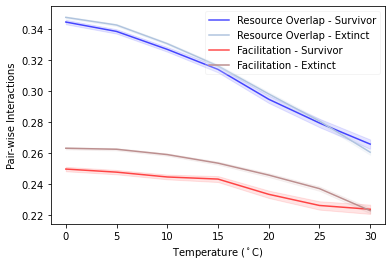

In [1]:
from Bacteria_vector_modular import ass_temp_run
import matplotlib.pylab as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

########## Setting Parameters ###########
N = 100 # Number of consumers
M = 50 # Number of resources

# Temperature params
Tref = 273.15 + 0 # Reference temperature
Ma = 1 # Mass
Ea_D = np.repeat(3.5,N) # High temperature inactivation
lf = 0.4 # Leakage fraction
p_value = 1 # External input resource concentration

# Assembly
ass = 30 # Assemblies at each temperature
t_fin = 4000 # Number of time steps for each temperature
typ = 1 # Functional response, Type I or II
K = 0 # Half saturation constant for Monod equation(Type II)
T_c = 7 # How many temperatures to cover

########## Running Model ###########
rich = np.empty((0, ass))
sur_CUE = []
ext_CUE = []
sur_overlap = []
ext_overlap = []
sur_crossf = []
ext_crossf = []

for i in range(T_c):
    T = 273.15 + 5 * i # Temperature
    result_array, rich_series, l, U_out_total, R_out, CUE_out, Ea_CUE_out, overlap, crossf = ass_temp_run(t_fin, N, M, T, Tref, Ma, ass, Ea_D, lf, p_value, typ, K)
    rich = np.append(rich, [rich_series.flatten()], axis = 0)
    sur = [np.where(result_array[(i+1)*t_fin-1, 0:N]) for i in range(ass)]
    ext = [np.where(result_array[(i+1)*t_fin-1, 0:N] == 0) for i in range(ass)]
    sur_CUE.append(np.concatenate([CUE_out[i][sur[i]] for i in range(len(sur))]))
    ext_CUE.append(np.concatenate([CUE_out[i][ext[i]] for i in range(len(ext))]))
    sur_overlap.append(np.concatenate([overlap[i][sur[i]] for i in range(len(sur))]))
    ext_overlap.append(np.concatenate([overlap[i][ext[i]] for i in range(len(ext))]))
    sur_crossf.append(np.concatenate([crossf[i][sur[i]] for i in range(len(sur))]))
    ext_crossf.append(np.concatenate([crossf[i][ext[i]] for i in range(len(ext))]))

T_plot = range(0, 5*T_c, 5)

rich_mean = np.mean(rich, axis = 1)
rich_ci =  1.96 * np.std(rich,axis = 1)/(T_c**0.5)
plt.plot(T_plot, rich_mean)
plt.fill_between(T_plot, rich_mean - rich_ci, rich_mean + rich_ci, color='b', alpha=.1)
plt.xlabel('Temperature ($^\circ$C)')
plt.ylabel('Richness')
plt.show()


CUE_mean = np.array([np.mean(sur_CUE[i]) for i in range(T_c)])
CUE_ci = np.array([1.96 * np.std(sur_CUE[i])/(len(ext_CUE[i])**0.5) for i in range(T_c)])
CUE_ext_mean = np.array([np.mean(ext_CUE[i]) for i in range(T_c)])
CUE_ext_ci = np.array([1.96 * np.std(ext_CUE[i])/(len(ext_CUE[i])**0.5) for i in range(T_c)])
plt.plot(T_plot, CUE_mean, 'r', label = "Survivor")
plt.fill_between(T_plot, CUE_mean - CUE_ci, CUE_mean + CUE_ci, color='r', alpha=.1)
plt.plot(T_plot, CUE_ext_mean, 'dimgrey', label = "Extinct")
plt.fill_between(T_plot,  CUE_ext_mean - CUE_ext_ci,  CUE_ext_mean + CUE_ext_ci, color='dimgrey', alpha=.1)
plt.xlabel('Temperature ($^\circ$C)')
plt.ylabel('CUE')
plt.legend()
plt.show()

overlap_sur_mean = np.array([np.mean(sur_overlap[i]) for i in range(T_c)])
overlap_sur_ci = np.array([1.96 * np.std(sur_overlap[i])/(len(sur_overlap[i])**0.5) for i in range(T_c)])
overlap_ext_mean = np.array([np.mean(ext_overlap[i]) for i in range(T_c)])
overlap_ext_ci = np.array([1.96 * np.std(ext_overlap[i])/(len(ext_overlap[i])**0.5) for i in range(T_c)])
crossf_sur_mean = np.array([np.mean(sur_crossf[i]) for i in range(T_c)])
crossf_sur_ci = np.array([1.96 * np.std(sur_overlap[i])/(len(sur_overlap[i])**0.5) for i in range(T_c)])
crossf_ext_mean = np.array([np.mean(ext_crossf[i]) for i in range(T_c)])
crossf_ext_ci = np.array([1.96 * np.std(ext_overlap[i])/(len(ext_overlap[i])**0.5) for i in range(T_c)])
plt.plot(T_plot, overlap_sur_mean, color = 'b', alpha = 0.7, label = 'Resource Overlap - Survivor')
plt.plot(T_plot, overlap_ext_mean, color = 'lightsteelblue', label = 'Resource Overlap - Extinct')
plt.fill_between(T_plot, overlap_sur_mean - overlap_sur_ci, overlap_sur_mean + overlap_sur_ci, color = 'b', alpha=.1)
plt.fill_between(T_plot, overlap_ext_mean - overlap_ext_ci, overlap_ext_mean + overlap_ext_ci, color = 'lightsteelblue', alpha=.1)
plt.plot(T_plot, crossf_sur_mean, color = 'r', alpha = 0.7, label = 'Facilitation - Survivor')
plt.plot(T_plot, crossf_ext_mean, color = 'rosybrown', label = 'Facilitation - Extinct')
plt.fill_between(T_plot, crossf_sur_mean - crossf_sur_ci, crossf_sur_mean + crossf_sur_ci, color = 'r', alpha=.1)
plt.fill_between(T_plot, crossf_ext_mean - crossf_ext_ci, crossf_ext_mean + crossf_ext_ci, color = 'rosybrown', alpha=.1)
plt.xlabel('Temperature ($^\circ$C)')
plt.ylabel('Pair-wise Interactions')
plt.legend(framealpha = 0.2, loc = 1)
plt.show()